In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from sklearn.metrics import classification_report, roc_auc_score

import pandas as pd
import numpy as np

import random
import pickle
import time

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, update_display
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRANSFORMS, DATASETS, DATALOADERS

In [3]:
size = (500, 500)

transform_identity = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_augment = transforms.Compose([
    transforms.Resize(size),
    
    # minor data augmentations
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)), # small rotation+translation+zoom, i.e. patient positional variance
    transforms.RandomAutocontrast(p=0.3), 
    transforms.Lambda(lambda x: F.adjust_gamma(x, random.uniform(0.8, 1.2))),  # gamma, i.e. exposure variation
    
    transforms.ToTensor(),
    
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01 * x.max()), # 0.5 noise    
    
    transforms.Normalize(mean=[0.5], std=[0.5])
])

sanity check:

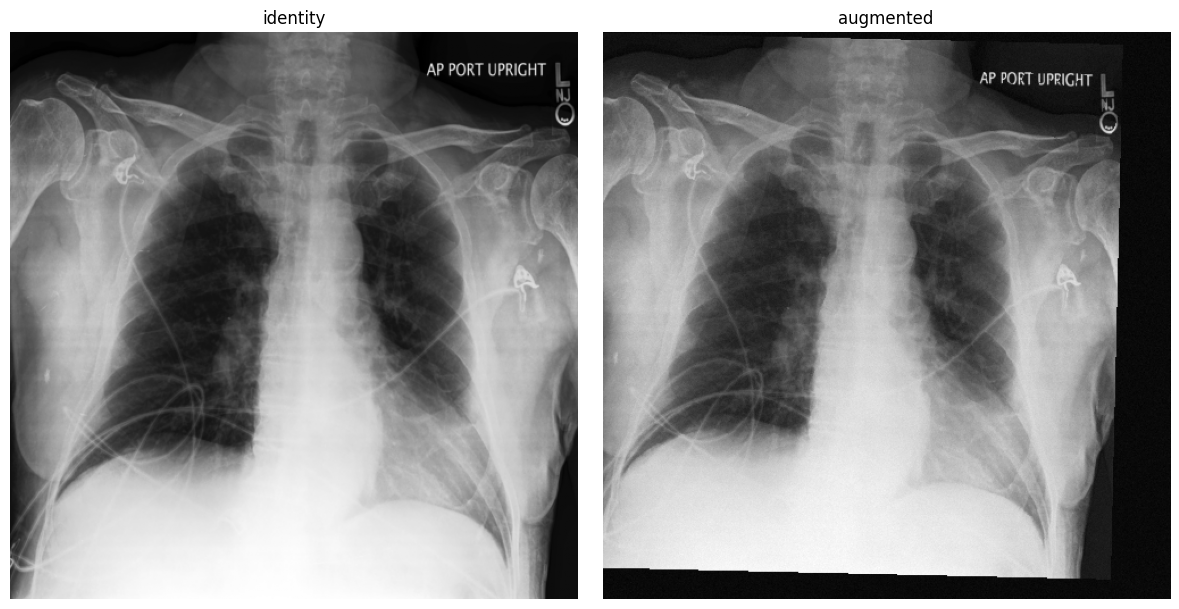

In [4]:
img = Image.open("patient64541_xray_positive_1-2-3.jpg") 

img_identity = transform_identity(img)  
img_augmented = transform_augment(img) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img_identity[0], cmap='gray')
ax1.set_title('identity')
ax1.axis('off')
ax2.imshow(img_augmented[0], cmap='gray')
ax2.set_title('augmented')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [5]:
BATCHSIZE = 32
# 46 is limit for 24gb

class CheXpertDataset(Dataset):
    def __init__(self, csv_path, image_root, transform, start_index):
        """
        Args:
            csv_path (str): Path to test_labels.csv
            image_root (str): Root directory for images (e.g., 'test/')
            transform (callable): transform to be applied
        """
        self.labels_df = pd.read_csv(csv_path)
        self.image_root = image_root
        self.transform = transform
        self.start_index = start_index

        self.classes = self.labels_df.columns.tolist()[start_index:] # extract the class names 
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx, 0]  # First column is 'Path'
        image = Image.open(f"{self.image_root}/{img_path}")
        image = self.transform(image)
        
        labels = self.labels_df.iloc[idx, self.start_index:].astype(np.float32).values
        labels = torch.from_numpy(labels).float()
                    
        return image, labels, img_path  


train_dataset = CheXpertDataset(
    # csv_path=".\\datasets\\chexpertchestxrays-u20210408\\train_visualCheXbert_SMALL.csv",
    csv_path=".\\datasets\\chexpertchestxrays-u20210408\\train_visualCheXbert.csv",
    image_root=".\\datasets\\chexpertchestxrays-u20210408", 
    transform=transform_augment,
    start_index=5
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_dataset = CheXpertDataset(
    csv_path=".\\datasets\\chexlocalize_test_val\\CheXpert\\val_labels.csv",
    image_root=".\\datasets\\chexlocalize_test_val\\CheXpert", 
    transform=transform_identity,
    start_index=5
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataset = CheXpertDataset(
    csv_path=".\\datasets\\chexlocalize_test_val\\CheXpert\\test_labels.csv",
    image_root=".\\datasets\\chexlocalize_test_val\\CheXpert", 
    transform=transform_identity,
    start_index=1
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
    
# Test single batches:
images, labels, paths = next(iter(train_loader))
print(f"Batch shape: {images.shape} Labels shape: {labels.shape}")  # Should be [B, 1, (size)], [B, 14]

images, labels, paths = next(iter(val_loader))
print(f"Batch shape: {images.shape} Labels shape: {labels.shape}")  # Should be [B, 1, (size)], [B, 14]

images, labels, paths = next(iter(test_loader))
print(f"Batch shape: {images.shape} Labels shape: {labels.shape}")  # Should be [B, 1, (size)], [B, 14]

if (train_dataset.classes == val_dataset.classes and val_dataset.classes == test_dataset.classes): 
    print("True")
    idx_to_class_name = train_dataset.classes
else:
    print("beeg problem")

Batch shape: torch.Size([32, 1, 500, 500]) Labels shape: torch.Size([32, 14])
Batch shape: torch.Size([32, 1, 500, 500]) Labels shape: torch.Size([32, 14])
Batch shape: torch.Size([32, 1, 500, 500]) Labels shape: torch.Size([32, 14])
True


# MODEL

In [6]:

class CheXpertResNet50(nn.Module):
    def __init__(self, pretrained=True, num_classes=14):
        super().__init__()
        # 1. Load pretrained ResNet-50
        backbone = models.resnet50(pretrained=pretrained)

        # 2. Replace the first conv to accept 1 channel
        #    Keep the original weights by summing across the RGB channels
        w = backbone.conv1.weight.data
        # w shape: (64, 3, 7, 7) -> average or sum to (64,1,7,7)
        w_gray = w.sum(dim=1, keepdim=True)  # sum RGB→gray
        new_conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=backbone.conv1.out_channels,
            kernel_size=backbone.conv1.kernel_size,
            stride=backbone.conv1.stride,
            padding=backbone.conv1.padding,
            bias=backbone.conv1.bias is not None
        )
        new_conv1.weight.data.copy_(w_gray)
        if backbone.conv1.bias is not None:
            new_conv1.bias.data.copy_(backbone.conv1.bias.data)

        # 3. Build feature extractor up through layer4
        self.features = nn.Sequential(
            new_conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
        )

        # 4. Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # 5. Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),                 
            nn.Dropout(p=0.2),            
            nn.Linear(backbone.layer4[-1].conv3.out_channels, num_classes),
            # nn.Sigmoid()
        )

        # 6. Expose layer4[-1] for Grad-CAM hooks
        self.gradcam_target = backbone.layer4[-1]

        # placeholders for hooks
        self.activations = None
        self.gradients   = None

        # register hooks
        def forward_hook(module, inp, out):
            # out: Tensor shape (B, C, H', W')
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            # grad_out[0]: same shape as activations
            self.gradients = grad_out[0].detach()

        self.gradcam_target.register_forward_hook(forward_hook)
        self.gradcam_target.register_full_backward_hook(backward_hook)

    def forward(self, x):
        """
        x: (B, 1, H, W) grayscale images
        """
        x = self.features(x)            # -> (B, 2048, h', w')
        # self.activations = x            # for Grad-CAM
        x = self.global_pool(x)         # -> (B, 2048, 1, 1)
        x = self.classifier(x)          # -> (B, 14)
        return x


In [7]:
model = CheXpertResNet50()
model.to(device)
model.load_state_dict(torch.load("e2_chexpert_resnet50.sav", map_location=device))

C:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# CAM STUFF 

In [8]:
HEATMAP_THRESHOLD = 0.2
BOX_LINE_WIDTH = 5
CENTER_RADIUS = 10
CAM_OPACITY = 0.25

# ─── compute_gradcam ──────────────────────────────────────────────
def compute_gradcam(model, input_tensor, class_idx):
    """
    model: CheXpertResNet50 with hooks
    input_tensor: shape (1,1,H,W)
    class_idx: int
    """
    # 1) Forward
    logits = model(input_tensor)              # (1,14)
    # 2) Zero grads & backward from target logit
    model.zero_grad()
    logits[0, class_idx].backward(retain_graph=True)

    # 3) Grab from model
    activations = model.activations           # (1, C, h', w')
    gradients   = model.gradients             # (1, C, h', w')

    # 4) Compute weights αᶜₖ
    weights = gradients.mean(dim=[0,2,3], keepdim=True)  # (1,C,1,1)

    # 5) Weighted combination & ReLU
    cam = torch.nn.functional.relu((weights * activations).sum(dim=1)).squeeze()  # (h',w')
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam.cpu().numpy()

# ─── extract_bbox_and_center ──────────────────────────────────────
def extract_bbox_and_center(cam, threshold=HEATMAP_THRESHOLD):
    """
    cam: HxW numpy array normalized [0,1]
    returns: bbox=(x0,y0,x1,y1), center=(cx,cy) in cam coords or (None,None)
    """
    mask = (cam >= threshold).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels <= 1:
        return None, None
    areas = stats[1:, cv2.CC_STAT_AREA]
    idx = areas.argmax() + 1
    x, y, w, h, _ = stats[idx]
    ys, xs = np.where(labels == idx)
    cx, cy = xs.mean(), ys.mean()
    return (x, y, x+w, y+h), (cx, cy)

# ─── overlay_heatmap_on_image ────────────────────────────────────
def overlay_heatmap_on_image(orig_pil, cam):
    """
    orig_pil: PIL.Image in grayscale (mode 'L')
    cam: (h', w') numpy array in [0,1]
    returns: PIL.Image with heatmap overlay
    """
    orig_np = np.array(orig_pil)  # shape (H, W)

    # Convert grayscale to 3-channel RGB
    if len(orig_np.shape) == 2:
        orig_np = np.stack([orig_np]*3, axis=-1)  # -> (H, W, 3)

    H, W = orig_np.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Blend
    overlay = (heatmap * CAM_OPACITY + orig_np * (1 - CAM_OPACITY)).astype(np.uint8)
    return Image.fromarray(overlay)


# ─── visualize_cam_for_class ─────────────────────────────────────
# def visualize_cam_for_class(model, orig_pil, input_tensor, class_idx, class_name=None, score=None):
#     """
#     Runs Grad-CAM for a single class on one image, returns:
#       - overlayed heatmap PIL.Image
#       - boxed PIL.Image (bbox + center + label)
#     """
#     # 1) compute CAM
#     cam = compute_gradcam(model, input_tensor, class_idx)

#     # 2) heatmap overlay
#     heatmap_img = overlay_heatmap_on_image(orig_pil, cam)

#     # 3) draw bbox + center + label on original
#     # boxed = orig_pil.copy()
#     boxed = orig_pil.convert("RGB").copy()
#     draw = ImageDraw.Draw(boxed)
#     font = ImageFont.load_default()
#     W, H = boxed.size

#     # resize cam to image size
#     cam_resized = cv2.resize(cam, (W, H))
#     bbox, center = extract_bbox_and_center(cam_resized)
#     if bbox is not None:
#         x0, y0, x1, y1 = bbox
#         cx, cy = center
#         # box & center
#         draw.rectangle([x0,y0,x1,y1], outline="red", width=BOX_LINE_WIDTH)
#         draw.ellipse([cx-CENTER_RADIUS, cy-CENTER_RADIUS,
#                       cx+CENTER_RADIUS, cy+CENTER_RADIUS],
#                      fill="red")
#         # label
#         label = f"{class_name or class_idx}{' '+f'{score:.2f}' if score is not None else ''}"
#         # measure
#         tb = draw.textbbox((0,0), label, font=font)
#         tw, th = tb[2]-tb[0], tb[3]-tb[1]
#         tx = min(max(cx + 10, 0), W - tw)
#         ty = min(max(cy - th/2, 0), H - th)
#         draw.rectangle([tx, ty, tx+tw, ty+th], fill="black")
#         draw.text((tx, ty), label, fill="yellow", font=font)

#     return heatmap_img, boxed

def visualize_cam_for_class(model, orig_pil, input_tensor, class_idx, class_name=None, score=None):
    """
    Compute and visualize Grad-CAM for a class index.
    Returns: overlayed heatmap with bounding box and label drawn ON TOP.
    """
    # 1. Compute CAM
    cam = compute_gradcam(model, input_tensor, class_idx)

    # 2. Convert grayscale to RGB base for drawing
    orig_np = np.array(orig_pil)
    if len(orig_np.shape) == 2:
        orig_np = np.stack([orig_np]*3, axis=-1)  # (H, W, 3)

    H, W = orig_np.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = (heatmap * CAM_OPACITY + orig_np * (1 - CAM_OPACITY)).astype(np.uint8)

    # 3. Create PIL image and draw
    combined = Image.fromarray(overlay).convert("RGB")
    draw = ImageDraw.Draw(combined)
    font = ImageFont.load_default()

    bbox, center = extract_bbox_and_center(cam_resized)
    if bbox is not None:
        x0, y0, x1, y1 = bbox
        cx, cy = center
        draw.rectangle([x0, y0, x1, y1], outline="purple", width=BOX_LINE_WIDTH)
        draw.ellipse([cx - CENTER_RADIUS, cy - CENTER_RADIUS,
                      cx + CENTER_RADIUS, cy + CENTER_RADIUS], fill="yellow")

        label = f"{class_name or class_idx}{' '+f'{score:.2f}' if score is not None else ''}"
        tb = draw.textbbox((0, 0), label, font=font)
        tw, th = tb[2] - tb[0], tb[3] - tb[1]
        tx = min(max(cx + 10, 0), W - tw)
        ty = min(max(cy - th / 2, 0), H - th)
        draw.rectangle([tx, ty, tx + tw, ty + th], fill="black")
        draw.text((tx, ty), label, fill="yellow", font=font)

    return combined



# RUN THE MODEL : TRAIN / TEST LOOP

In [9]:
# model(images).shape


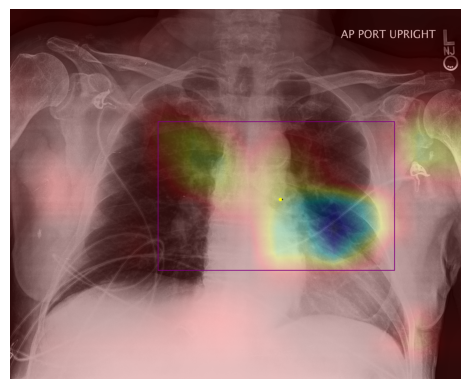

Cardiomegaly


In [10]:
# UNTRAINED MODEL 
boxed_heatmap = visualize_cam_for_class(
    model, 
    orig_pil=img, 
    input_tensor=transform_augment(img).unsqueeze(0).to(device) , 
    class_idx=2 # 
)
plt.imshow(boxed_heatmap)
plt.axis('off')
plt.show()
print(idx_to_class_name[2])

CHEXPERT PAPER:Images are fed into the network with
size 320 × 320 pixels. We use the Adam optimizer with de-
fault β-parameters of β1 = 0.9, β2 = 0.999 and learning
rate 1 × 10−4 which is fixed for the duration of the training.
Batches are sampled using a fixed batch size of 16 images.
We train for 3 epochs, saving checkpoints every 4800 itera-
tions.

### handle metrics

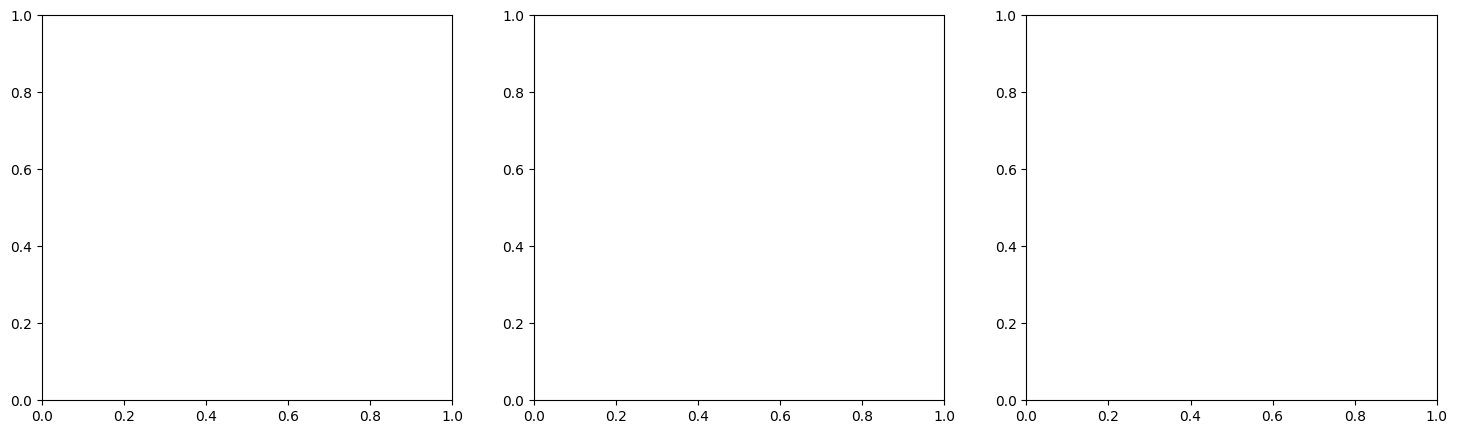

In [11]:
train_losses, val_losses = [], []
train_accs, val_accs     = [], []
train_aurocs, val_aurocs = [], []

# Set up one-time figure
plot_fig, plot_axes = plt.subplots(1, 3, figsize=(18, 5))
plot_display_id = None  # needed for persistent inline update

def update_plots():
    global plot_display_id

    epochs = range(1, len(train_losses) + 1)

    # Clear axes
    for ax in plot_axes:
        ax.cla()

    # Plot Loss
    plot_axes[0].plot(epochs, train_losses, label="Train")
    plot_axes[0].plot(epochs, val_losses, label="Val")
    plot_axes[0].set_title("Loss")
    plot_axes[0].set_xlabel("Epoch")
    plot_axes[0].legend()
    plot_axes[0].grid(True)

    # Plot Accuracy
    plot_axes[1].plot(epochs, train_accs, label="Train")
    plot_axes[1].plot(epochs, val_accs, label="Val")
    plot_axes[1].set_title("Accuracy")
    plot_axes[1].set_xlabel("Epoch")
    plot_axes[1].legend()
    plot_axes[1].grid(True)

    # Plot AUROC
    plot_axes[2].plot(epochs, train_aurocs, label="Train")
    plot_axes[2].plot(epochs, val_aurocs, label="Val")
    plot_axes[2].set_title("AUROC")
    plot_axes[2].set_xlabel("Epoch")
    plot_axes[2].legend()
    plot_axes[2].grid(True)

    plot_fig.tight_layout()

    if plot_display_id is None:
        display(plot_fig, display_id="training_plot")
        plot_display_id = "training_plot"
    else:
        update_display(plot_fig, display_id=plot_display_id)

## train / val helpers

In [12]:
# Training and evaluation loops
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    iteration = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for images, labels, _ in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images)                    # shape [B,14]
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        # accumulate
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).detach().cpu()
        preds = (probs >= 0.5).int()
        
        all_preds.append(preds)
        all_labels.append(labels.cpu().int())
        
        # checkpoint every 4800 iterations
        # iteration += 1
        # if iteration % 4800 == 0:
        #     update_plots()
        #     torch.save(model.state_dict(), f"checkpoint_epoch{epoch}_iter{iteration}.pth")
        
        pbar.set_postfix(loss=loss.item())
    
    # epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    epoch_acc = (all_preds == all_labels).float().mean().item()
    
    try:
        # Get probabilities from preds (already thresholded), or recompute from logits
        probs = all_preds.float()  # or re-run sigmoid on stored logits if you want
        epoch_auroc = np.mean([
            roc_auc_score(all_labels[:, i].numpy(), probs[:, i].numpy())
            for i in range(all_labels.shape[1])
            if len(torch.unique(all_labels[:, i])) > 1
        ])
    except ValueError:
        epoch_auroc = 0.0  # fallback if no variability
    
    return epoch_loss, epoch_acc, epoch_auroc

@torch.no_grad()
def evaluate(epoch, loader=val_loader, verbose=True):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False)
    for images, labels, _ in pbar:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).cpu()
        preds = (probs >= 0.5).int()
        
        all_preds.append(preds)
        all_labels.append(labels.cpu().int())
        all_probs.append(probs)
    
    epoch_loss = running_loss / len(val_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    per_class_acc = (all_preds == all_labels).float().mean(dim=0) 
    print(per_class_acc)
    epoch_acc = (all_preds == all_labels).float().mean().item()

    # === AUROC ===
    # per-class AUROC, then mean
    aurocs = []
    for i in range(all_labels.shape[1]):
        if len(torch.unique(all_labels[:,i]))>1:
            aurocs.append(roc_auc_score(all_labels[:,i].numpy(), all_probs[:,i].numpy()))
    epoch_auroc = float(np.mean(aurocs)) if aurocs else 0.0

    if verbose:
        print('per class aurocs', aurocs ) # can extract per class aurocs here
        print("\nClassification Report (per class):")
        print(classification_report(
            all_labels.numpy(),
            all_preds.numpy(),
            target_names=idx_to_class_name,
            zero_division=0  # to avoid warnings for classes with no positive preds
        ))
    
    return epoch_loss, epoch_acc, epoch_auroc

## actually run the model

In [13]:
best_val_loss = float("inf")
criterion = nn.BCEWithLogitsLoss()  # model outputs logits
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-5)

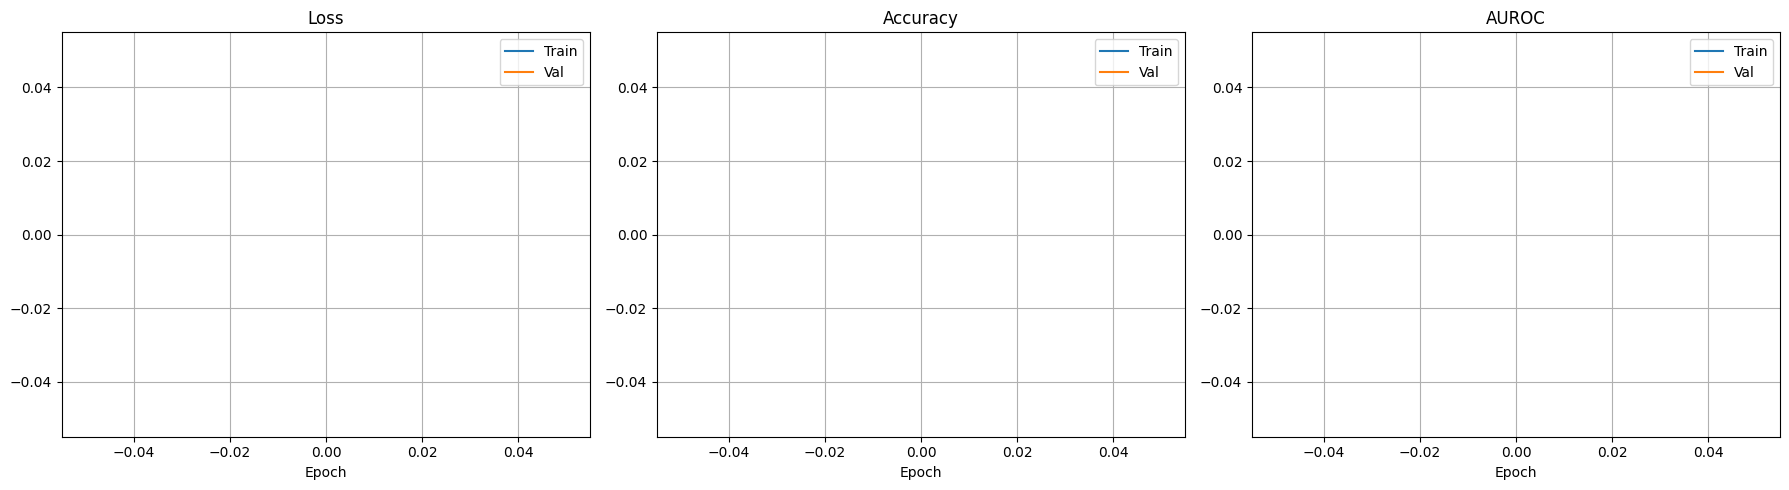

tensor([0.9103, 0.7393, 0.7479, 0.8248, 0.9530, 0.8462, 0.8462, 0.9402, 0.8120,
        0.9316, 0.8291, 0.9915, 0.8504, 0.8974])
per class aurocs [np.float64(0.9644199785177229), np.float64(0.8433761467889909), np.float64(0.8119241672572644), np.float64(0.9081422692533804), np.float64(0.8669527896995708), np.float64(0.8881834215167548), np.float64(0.915121362882557), np.float64(0.9004424778761062), np.float64(0.8912337662337662), np.float64(0.8152654867256638), np.float64(0.9059790866029136), np.float64(0.4763948497854077), np.float64(0.9608506880565163)]

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.66      0.92      0.77        38
Enlarged Cardiomediastinum       0.68      0.84      0.75       109
              Cardiomegaly       0.55      0.71      0.62        68
              Lung Opacity       0.85      0.82      0.83       126
               Lung Lesion       0.00      0.00      0.00    

CheXpertResNet50(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [14]:

# Main training loop
num_epochs = 1
start_time = time.time()
update_plots()

for epoch in range(1, num_epochs+1):
    epoch_start = time.time()
    
    tr_loss, tr_acc, tr_auroc = train_one_epoch(epoch)
    val_loss, val_acc, val_auroc = evaluate(epoch)
    
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    train_aurocs.append(tr_auroc)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aurocs.append(val_auroc)

    # Time tracking
    total_elapsed = time.time() - start_time
    eta = (num_epochs - epoch) * (time.time() - epoch_start) # epochs remaining * epoch_duration
    # Convert time in seconds to mm:ss
    def format_time(t):
        m, s = divmod(int(t), 60)
        return f"{m:02d}:{s:02d}"
    
    print(f"Epoch {epoch} | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f}, AUROC: {tr_auroc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUROC: {val_auroc:.4f}")
    print(f"Elapsed: {format_time(total_elapsed)} | ETA: {format_time(eta)}")
    
    # save best
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), f"{epoch}_chexpert_resnet50.sav")
    #     print("Saved best model.")
    
    # update_plots()

model.eval() # just in case

In [15]:
torch.save(model.state_dict(), f"e3_chexpert_resnet50.sav")

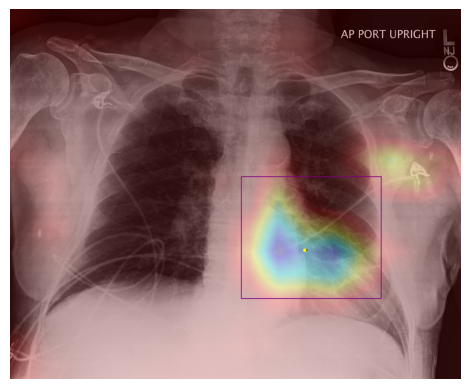

tensor([[-0.1883, -0.0096, -0.6430, -1.0889, -3.9730, -1.2315, -3.2003, -3.6398,
         -2.1003, -4.1117, -3.1727, -3.3440, -2.0917, -1.9760]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
# img = Image.open("patient64541_xray_positive_1-2-3.jpg") 
boxed_heatmap = visualize_cam_for_class(
    model, 
    orig_pil=img, 
    input_tensor=transform_identity(img).unsqueeze(0).to(device) , 
    class_idx=2 # 5 is edema
)
plt.imshow(boxed_heatmap)
plt.axis('off')
plt.show()

model(transform_identity(img).unsqueeze(0).to(device))

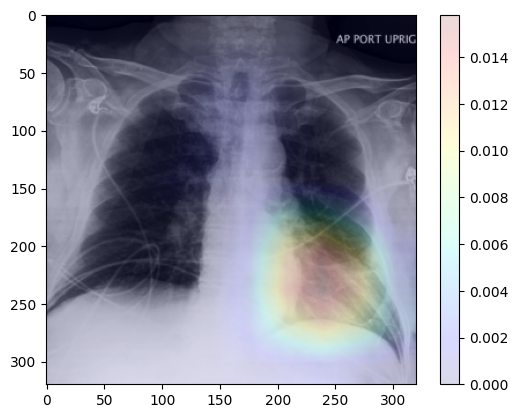

In [21]:
# COMPARE TO VAL 
# Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity # 1 2 3 respectively
path1="datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Enlarged Cardiomediastinum_map.pkl"
path2="datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Cardiomegaly_map.pkl"
path3="datasets/chexlocalize_test_val/CheXlocalize/gradcam_maps_val/patient64541_study1_view1_frontal_Airspace Opacity_map.pkl"

with open(path2, "rb") as f:
    pkl = pickle.load(f)
    cxr_img = pkl['cxr_img'].permute(1, 2, 0)
    heatmap = pkl['map'].squeeze()

plt.imshow(cxr_img, cmap="gray")
plt.imshow(heatmap, cmap="jet", alpha=0.15) 

plt.colorbar()
plt.show()

In [55]:
evaluate(epoch) # epoch 1

tensor([0.8974, 0.7350, 0.6838, 0.8291, 0.9274, 0.7094, 0.8291, 0.9316, 0.7991,
        0.9145, 0.8162, 0.9915, 0.8632, 0.9060])

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.64      0.84      0.73        38
Enlarged Cardiomediastinum       0.66      0.91      0.76       109
              Cardiomegaly       0.48      0.90      0.62        68
              Lung Opacity       0.84      0.84      0.84       126
               Lung Lesion       0.00      0.00      0.00         1
                     Edema       0.39      0.91      0.55        45
             Consolidation       0.44      0.82      0.57        33
                 Pneumonia       0.25      0.50      0.33         8
               Atelectasis       0.82      0.53      0.64        80
              Pneumothorax       0.20      0.50      0.29         8
          Pleural Effusion       0.80      0.48      0.60        67
             Pleur

(0.35823677722205466, 0.8452380895614624, 0.8364994628797346)

In [22]:
evaluate(epoch) #  epoch 2

tensor([0.9188, 0.7607, 0.7479, 0.8590, 0.9017, 0.8761, 0.7521, 0.9188, 0.8291,
        0.8547, 0.8504, 0.9658, 0.7265, 0.8761])
per class aurocs [np.float64(0.958780880773362), np.float64(0.8448440366972477), np.float64(0.801293408929837), np.float64(0.9227660199882421), np.float64(0.6523605150214593), np.float64(0.9162845385067606), np.float64(0.9001959897482286), np.float64(0.855641592920354), np.float64(0.8913149350649351), np.float64(0.9065265486725664), np.float64(0.9131289659486996), np.float64(0.5708154506437768), np.float64(0.9556258738685701)]

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.69      0.92      0.79        38
Enlarged Cardiomediastinum       0.72      0.80      0.76       109
              Cardiomegaly       0.55      0.72      0.62        68
              Lung Opacity       0.87      0.87      0.87       126
               Lung Lesion       0.00      0.00      0.00      

(0.36172799192942107, 0.8455433249473572, 0.8530445197526184)

In [17]:
evaluate(epoch) #  epoch 3

tensor([0.9103, 0.7393, 0.7479, 0.8248, 0.9530, 0.8462, 0.8462, 0.9402, 0.8120,
        0.9316, 0.8291, 0.9915, 0.8504, 0.8974])
per class aurocs [np.float64(0.9644199785177229), np.float64(0.8433761467889909), np.float64(0.8119241672572644), np.float64(0.9081422692533804), np.float64(0.8669527896995708), np.float64(0.8881834215167548), np.float64(0.915121362882557), np.float64(0.9004424778761062), np.float64(0.8912337662337662), np.float64(0.8152654867256638), np.float64(0.9059790866029136), np.float64(0.4763948497854077), np.float64(0.9608506880565163)]

Classification Report (per class):
                            precision    recall  f1-score   support

                No Finding       0.66      0.92      0.77        38
Enlarged Cardiomediastinum       0.68      0.84      0.75       109
              Cardiomegaly       0.55      0.71      0.62        68
              Lung Opacity       0.85      0.82      0.83       126
               Lung Lesion       0.00      0.00      0.00    

(0.3152532931576427, 0.8656898736953735, 0.8575604993228164)